In [1]:
import os
import torch
import numpy as np
from qdrant_client import QdrantClient
from qdrant_client.http import models
from tqdm import tqdm
from datasets import load_dataset

In [2]:
from PIL import Image

def read_png_files(directory):
    png_images = []
    for filename in os.listdir(directory):
        if filename.endswith('.png'):
            image_path = os.path.join(directory, filename)
            img = Image.open(image_path)
            img.filename = filename
            # Extract page number from filename like "doc.pdf_page_1.png"
            if '_page_' in filename:
                page_num = int(filename.split('_page_')[-1].split('.')[0])
                img.page_number = page_num
            png_images.append(img)
    return png_images

# Read all PNG files from the prepared data directory
dataset = read_png_files("../data/prepared_data/")
print(f"Loaded {len(dataset)} PNG images")

Loaded 2218 PNG images


In [3]:
qdrant_client = QdrantClient(host="localhost")
# QdrantClient(
#     ":memory:"
# )  # Use ":memory:" for in-memory database or "path/to/db" for persistent storage

In [4]:
from colpali_engine.models import ColQwen2, ColQwen2Processor

colpali_model = ColQwen2.from_pretrained(
    "vidore/colqwen2-v0.1",
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",  # or "mps" if on Apple Silicon
)
colpali_processor = ColQwen2Processor.from_pretrained("vidore/colqwen2-v0.1")

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# sample_image = dataset[0]
# with torch.no_grad():
#     sample_batch = colpali_processor.process_images([sample_image]).to(
#         colpali_model.device
#     )
#     sample_embedding = colpali_model(**sample_batch)

In [6]:
# vector_size = sample_embedding.shape[2]
# vector_size

In [7]:
collection_name = "nornikel_prod"

In [8]:
qdrant_client.collection_exists(collection_name)

True

In [9]:
# vector_params = models.VectorParams(
#     size=vector_size,
#     distance=models.Distance.COSINE,
#     multivector_config=models.MultiVectorConfig(
#         comparator=models.MultiVectorComparator.MAX_SIM
#     ),
# )

In [10]:
# scalar_quant = models.ScalarQuantizationConfig(
#     type=models.ScalarType.INT8,
#     quantile=0.99,
#     always_ram=False,
# )

In [11]:
# qdrant_client.recreate_collection(
#     collection_name=collection_name,  # the name of the collection
#     on_disk_payload=True,  # store the payload on disk
#     optimizers_config=models.OptimizersConfigDiff(
#         indexing_threshold=100
#     ),  # it can be useful to swith this off when doing a bulk upload and then manually trigger the indexing once the upload is done
#     vectors_config=models.VectorParams(
#         size=vector_size,
#         distance=models.Distance.COSINE,
#         multivector_config=models.MultiVectorConfig(
#             comparator=models.MultiVectorComparator.MAX_SIM
#         ),
#         quantization_config=models.ScalarQuantization(
#             scalar=models.ScalarQuantizationConfig(
#                 type=models.ScalarType.INT8,
#                 quantile=0.99,
#                 always_ram=True,
#             ),
#         ),
#     ),
# )

In [12]:
# import stamina


# @stamina.retry(on=Exception, attempts=3)
# def upsert_to_qdrant(batch):
#     try:
#         qdrant_client.upsert(
#             collection_name=collection_name,
#             points=points,
#             wait=False,
#         )
#     except Exception as e:
#         print(f"Error during upsert: {e}")
#         return False
#     return True

In [13]:
# batch_size = 2  # Adjust based on your GPU memory constraints

# # Use tqdm to create a progress bar
# with tqdm(total=len(dataset), desc="Indexing Progress") as pbar:
#     for i in range(0, len(dataset), batch_size): # len(dataset)
#         batch = dataset[i : i + batch_size]

#         # The images are already PIL Image objects, so we can use them directly
#         images = batch

#         # Process and encode images
#         with torch.no_grad():
#             batch_images = colpali_processor.process_images(images).to(
#                 colpali_model.device
#             )
#             image_embeddings = colpali_model(**batch_images)

#         # Prepare points for Qdrant
#         points = []
#         for j, embedding in enumerate(image_embeddings):
#             # Convert the embedding to a list of vectors
#             multivector = embedding.cpu().float().numpy().tolist()
#             points.append(
#                 models.PointStruct(
#                     id=i + j,  # we just use the index as the ID
#                     vector=multivector,  # This is now a list of vectors
#                     payload={
#                         "source": "internet archive"
#                     },  # can also add other metadata/data
#                 )
#             )
#         # Upload points to Qdrant
#         try:
#             upsert_to_qdrant(points)
#         # clown level error handling here 🤡
#         except Exception as e:
#             print(f"Error during upsert: {e}")
#             continue

#         # Update the progress bar
#         pbar.update(batch_size)

# print("Indexing complete!")

In [14]:
# qdrant_client.update_collection(
#     collection_name=collection_name,
#     optimizer_config=models.OptimizersConfigDiff(indexing_threshold=10),
# )

In [15]:
from rich import print as r_print

collection = qdrant_client.get_collection(collection_name)
r_print(collection)

CollectionInfo(
    status=<CollectionStatus.GREY: 'grey'>,
    optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>,
    vectors_count=None,
    indexed_vectors_count=2202,
    points_count=2218,
    segments_count=9,
    config=CollectionConfig(
        params=CollectionParams(
            vectors=VectorParams(
                size=128,
                distance=<Distance.COSINE: 'Cosine'>,
                hnsw_config=None,
                quantization_config=ScalarQuantization(
                    scalar=ScalarQuantizationConfig(
                        type=<ScalarType.INT8: 'int8'>,
                        quantile=0.99,
                        always_ram=True
                    )
                ),
                on_disk=None,
                datatype=None,
                multivector_config=MultiVectorConfig(comparator=<MultiVectorComparator.MAX_SIM: 'max_sim'>)
            ),
            shard_number=1,
            sharding_method=None,
            replication_factor=1,
            write_consistency_factor=1,
            read_fan_out_factor=None,
            on_disk_payload=True,
            sparse_vectors=None
        ),
        hnsw_config=HnswConfig(
            m=16,
            ef_construct=100,
            full_scan_threshold=10000,
            max_indexing_threads=0,
            on_disk=False,
            payload_m=None
        ),
        optimizer_config=OptimizersConfig(
            deleted_threshold=0.2,
            vacuum_min_vector_number=1000,
            default_segment_number=0,
            max_segment_size=None,
            memmap_threshold=None,
            indexing_threshold=100,
            flush_interval_sec=5,
            max_optimization_threads=None
        ),
        wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0),
        quantization_config=None
    ),
    payload_schema={}
)

In [16]:
qdrant_client.scroll(collection_name=collection_name, limit=10)

([Record(id=0, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=1, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=2, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=3, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=4, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=5, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=6, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=7, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=8, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=9, payload={'source': 'internet archive'}, vector=None, shard

In [17]:
query_text = "обращение председателя совета директоров"
with torch.no_grad():
    batch_query = colpali_processor.process_queries([query_text]).to(
        colpali_model.device
    )
    query_embedding = colpali_model(**batch_query)
query_embedding

tensor([[[-0.0713, -0.0116, -0.0109,  ...,  0.0317,  0.0027,  0.1021],
         [-0.1387, -0.0520,  0.1748,  ...,  0.1064,  0.0947, -0.0232],
         [ 0.0060,  0.0684,  0.0309,  ..., -0.0361,  0.0177,  0.0269],
         ...,
         [-0.1309,  0.0251,  0.0347,  ...,  0.0806,  0.1719,  0.0266],
         [-0.1318,  0.0432,  0.0383,  ...,  0.0898,  0.2158,  0.0131],
         [-0.1318,  0.0302,  0.0518,  ...,  0.1079,  0.1582,  0.0071]]],
       device='cuda:0', dtype=torch.bfloat16)

In [18]:
query_embedding[0].shape

torch.Size([23, 128])

In [19]:
# Convert the query embedding to a list of vectors
multivector_query = query_embedding[0].cpu().float().numpy().tolist()

In [20]:
# Search in Qdrant
search_result = qdrant_client.query_points(
    collection_name=collection_name, query=multivector_query, limit=10, timeout=60
)

search_result.points

[ScoredPoint(id=615, version=307, score=16.286692, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=762, version=381, score=16.277355, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=760, version=380, score=15.670669, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=1780, version=890, score=15.551525, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=1329, version=664, score=15.362694, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=176, version=88, score=15.211731, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=1138, version=569, score=15.204642, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=1353, ver

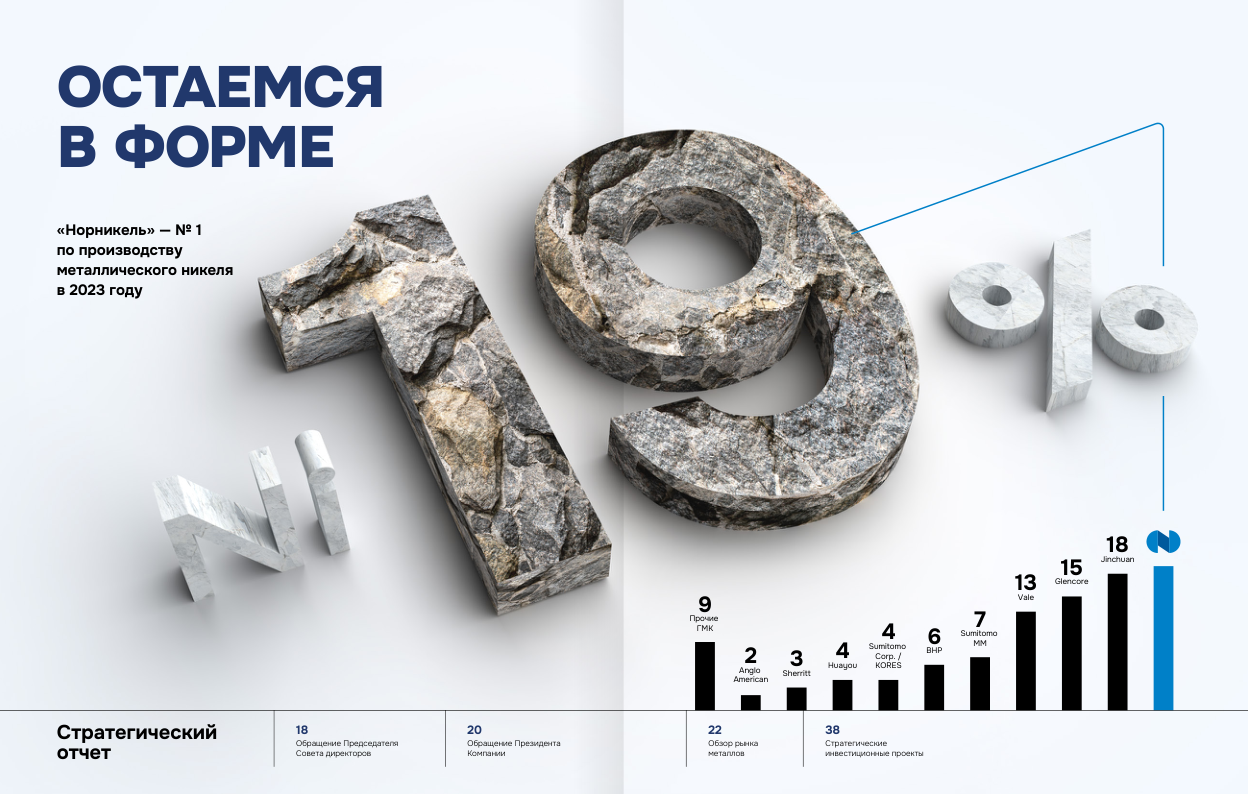

In [21]:
idx = search_result.points[0].id
dataset[idx]

In [22]:
def search_images_by_text(query_text, top_k=5):
    # Process and encode the text query
    with torch.no_grad():
        batch_query = colpali_processor.process_queries([query_text]).to(
            colpali_model.device
        )
        query_embedding = colpali_model(**batch_query)

    # Convert the query embedding to a list of vectors
    multivector_query = query_embedding[0].cpu().float().numpy().tolist()
    # Search in Qdrant
    search_result = qdrant_client.query_points(
        collection_name=collection_name, query=multivector_query, limit=top_k
    )

    return search_result


# Example usage
query_text = "declassified data"
results = search_images_by_text(query_text)

for result in results.points:
    print(result)

id=1035 version=517 score=8.370769 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None
id=143 version=71 score=7.1055183 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None
id=962 version=481 score=7.0334635 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None
id=2176 version=1088 score=6.9320774 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None
id=382 version=191 score=6.896802 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None


In [23]:
def search_by_text_and_return_images(query_text, top_k=5):
    results = search_images_by_text(query_text, top_k)
    row_ids = [r.id for r in results.points]
    return [dataset[i] for i in row_ids]

In [33]:
question = "Какое количество заседаний правительства было в двадцать первом году"

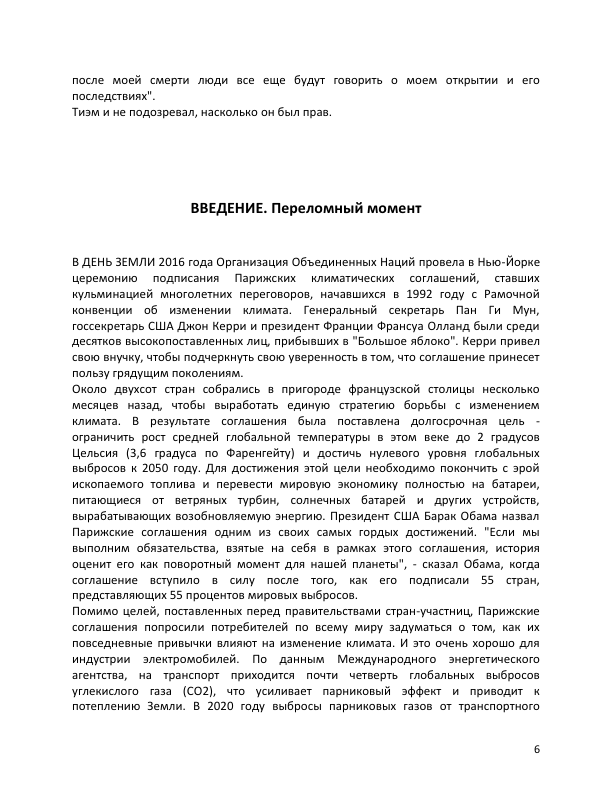

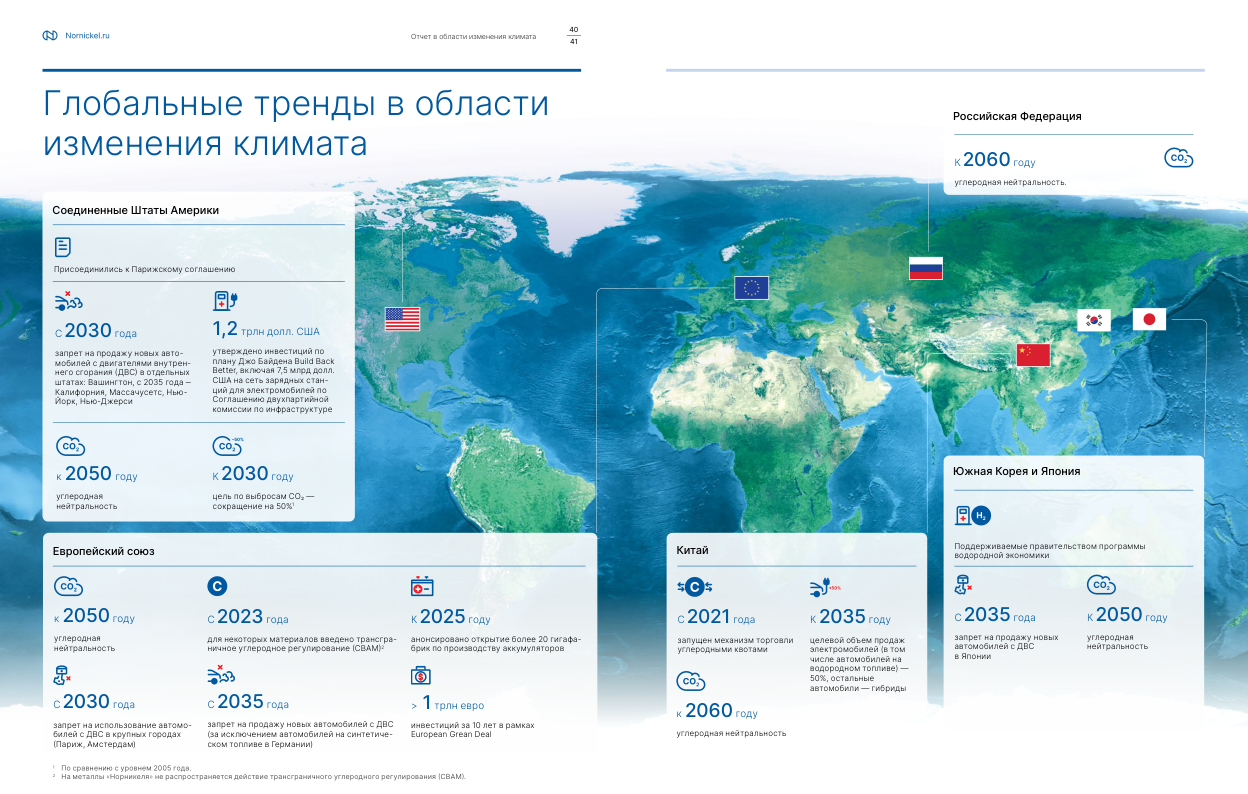

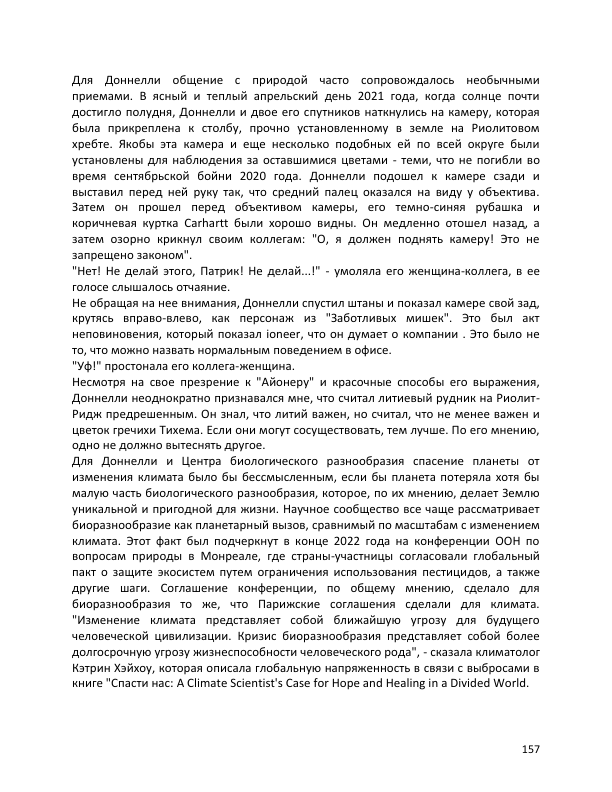

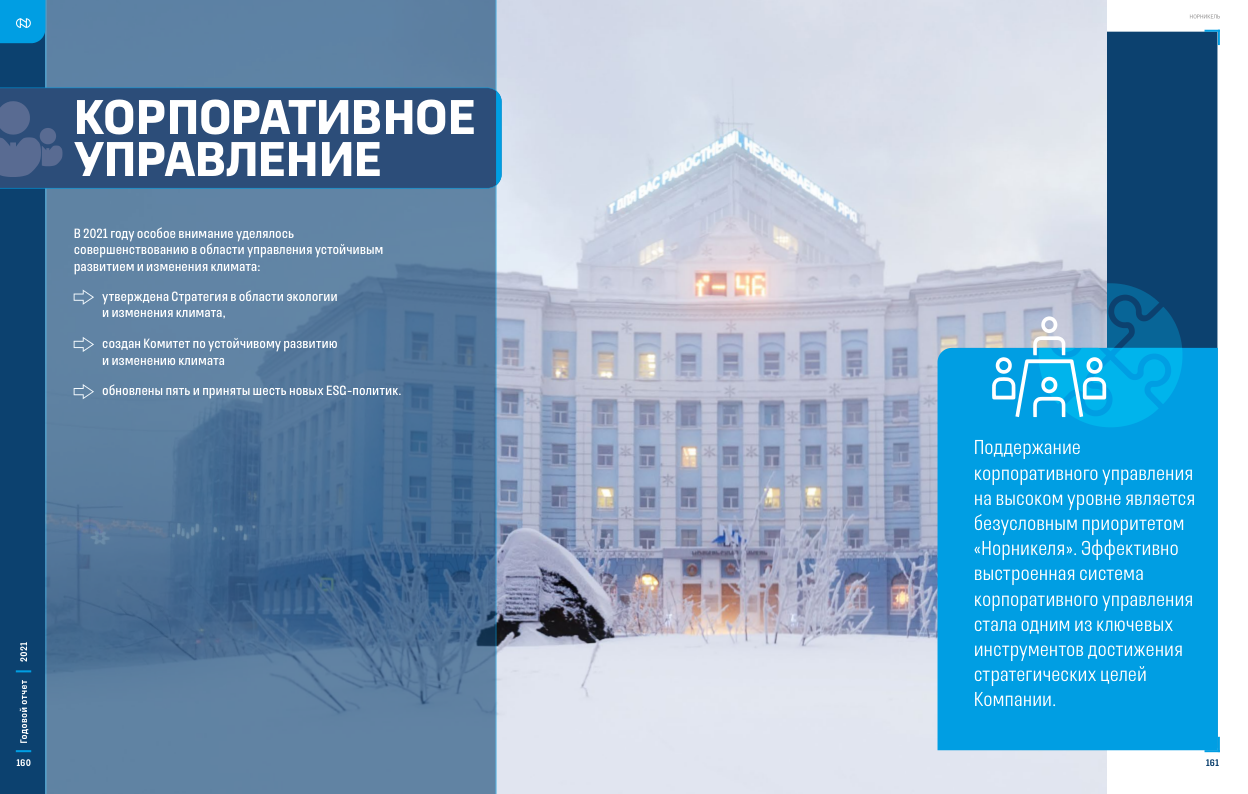

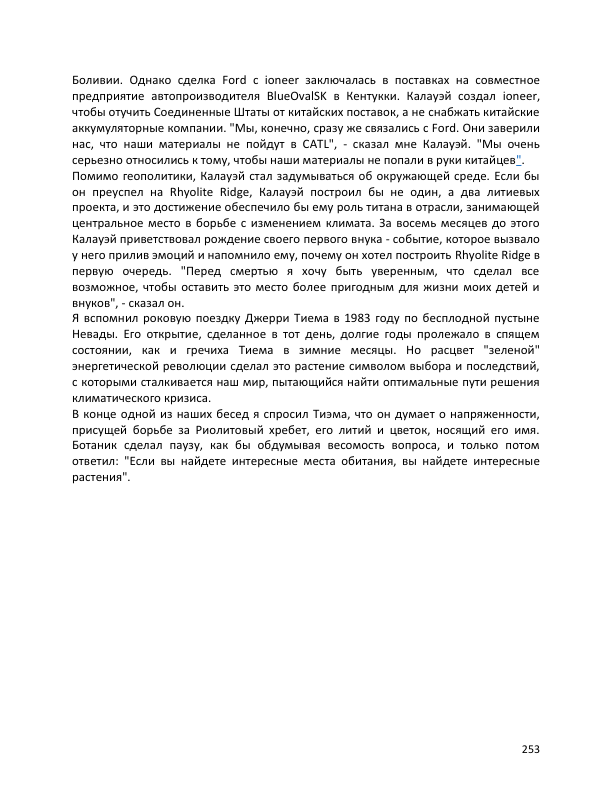

In [47]:
question = "кого привёл Джон Керри на церемонию подписания климатических соглашений"
results_ds = search_by_text_and_return_images(question)

for row in results_ds:
    # display image
    display(row)

In [48]:
filename = results_ds[0].filename
page = int(filename.split('_page_')[1].split('.')[0]) - 1
raw_filename = filename.split('_page_')[0]
print(f"Page: {page}")
print(f"Raw filename: {raw_filename}")

Page: 5
Raw filename: 2_5366183129474161642.pdf


In [51]:
import os
import PyPDF2

def get_text_from_pdf_page(pdf_path, page_number):
    # Open the PDF file
    with open(pdf_path, 'rb') as file:
        # Create a PDF reader object
        pdf_reader = PyPDF2.PdfReader(file)
        
        # Check if page number is valid
        if page_number >= len(pdf_reader.pages):
            return f"Error: PDF has only {len(pdf_reader.pages)} pages"
            
        # Get the specified page
        page = pdf_reader.pages[page_number]
        
        # Extract text from the page
        text = page.extract_text()
        
        return text

# Get text from page 91
pdf_path = f'../data/raw_files/{raw_filename}'
page_text = get_text_from_pdf_page(pdf_path, page)


Overwriting cache for 0 5388


In [52]:
page_text

' \n 6 после моей смерти люди все еще будут говорить о моем  открытии и его \nпоследствиях".  \nТиэм и не подозревал, насколько он был прав.  \n  \n \nВВЕДЕНИЕ . Переломный момент  \nВ ДЕНЬ ЗЕМЛИ 2016 года Организация Объединенных Наций провела в Нью -Йорке \nцеремонию подписания Парижских климатических соглашений, ставших \nкульминацией многолетних переговоров, начавшихся в 1992 году с Рамочной \nконвенции об изменении климата. Генеральный секретарь Пан Ги Мун, \nгоссекретарь США Джон Керри и президент Франции Франсуа Олланд были среди \nдесятков высокопоставленных лиц, прибывших в  "Большое яблоко".  Керри привел \nсвою внучку, чтобы подчеркнуть свою уверенность в том, что соглашение принесет \nпользу грядущим поколениям.  \nОколо дв ухсот стран собрались в пригороде французской столицы несколько \nмесяцев назад, чтобы выработать единую стратегию борьбы с изменением \nклимата. В результате соглашения была поставлена долгосрочная цель - \nограничить рост средней глобальной температуры

In [53]:
# from llama_cpp import Llama

# llm = Llama.from_pretrained(
# 	repo_id="bartowski/Mistral-Nemo-Instruct-2407-GGUF",
# 	filename="Mistral-Nemo-Instruct-2407-IQ2_M.gguf",
# 	n_ctx=4096,
# )

In [54]:
# import torch
# from PIL import Image
# from transformers import AutoModel, AutoTokenizer

# model = AutoModel.from_pretrained('openbmb/MiniCPM-V', trust_remote_code=True, torch_dtype=torch.bfloat16)
# # model = model.to(device='cuda', dtype=torch.bfloat16)
# model = model.to(device='cuda', dtype=torch.float16)

# tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V', trust_remote_code=True)
# model.eval()

In [55]:
# import torch
# from PIL import Image
# from transformers import AutoModel, AutoTokenizer

# torch.manual_seed(0)

# model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6', trust_remote_code=True,
#     attn_implementation='sdpa', torch_dtype=torch.bfloat16) # sdpa or flash_attention_2, no eager
# model = model.eval().cuda()
# tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6', trust_remote_code=True)

# image = Image.open('1280px-Sunflower_from_Silesia2.jpg').convert('RGB')

# # First round chat 
# question = "Tell me the model of this aircraft."
# msgs = [{'role': 'user', 'content': [image, question]}]

# answer = model.chat(
#     image=None,
#     msgs=msgs,
#     tokenizer=tokenizer
# )
# print(answer)

# # Second round chat 
# # pass history context of multi-turn conversation
# msgs.append({"role": "assistant", "content": [answer]})
# msgs.append({"role": "user", "content": ["Introduce something about Airbus A380."]})

# answer = model.chat(
#     image=None,
#     msgs=msgs,
#     tokenizer=tokenizer
# )
# print(answer)

In [31]:
# test.py
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
model.eval()

image = Image.open('1280px-Sunflower_from_Silesia2.jpg').convert('RGB')
question = 'What is in the image?'
msgs = [{'role': 'user', 'content': [image, question]}]

res = model.chat(
    image=None,
    msgs=msgs,
    tokenizer=tokenizer
)
print(res)

## if you want to use streaming, please make sure sampling=True and stream=True
## the model.chat will return a generator
# res = model.chat(
#     image=None,
#     msgs=msgs,
#     tokenizer=tokenizer,
#     sampling=True,
#     temperature=0.7,
#     stream=True
# )

# generated_text = ""
# for new_text in res:
#     generated_text += new_text
#     print(new_text, flush=True, end='')


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/233k [00:00<?, ?B/s]

c:\Users\igorl\py_projects\rag_hackaton_mvp\myenv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\igorl\.cache\huggingface\hub\models--openbmb--MiniCPM-V-2_6-int4. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model-00001-of-00002.safetensors:   0%|          | 0.00/4.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/5.64k [00:00<?, ?B/s]

tokenization_minicpmv_fast.py:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- tokenization_minicpmv_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.56k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

processing_minicpmv.py:   0%|          | 0.00/9.96k [00:00<?, ?B/s]

image_processing_minicpmv.py:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- processing_minicpmv.py
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
c:\Users\igorl\py_projects\rag_hackaton_mvp\myenv\Lib\site-packages\transformers\models\auto\image_processing_auto.py:520: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


The image features a single sunflower with its bright yellow petals and dark brown center, set against a clear blue sky.


In [56]:
question

'кого привёл Джон Керри на церемонию подписания климатических соглашений'

In [57]:
image = results_ds[0]
msgs = [{'role': 'user', 'content': [image, question]}]

res = model.chat(
    image=image,
    msgs=msgs,
    tokenizer=tokenizer
)

In [58]:
res

'Джон Керри привел французского президента Франсуа Олланду на церемонию подписания климатических соглашений'

In [59]:
from llama_cpp import Llama

llm = Llama.from_pretrained(
	repo_id="bartowski/Mistral-Nemo-Instruct-2407-GGUF",
	filename="Mistral-Nemo-Instruct-2407-IQ2_M.gguf",
	n_ctx=4096,
)

llama_model_loader: loaded meta data with 44 key-value pairs and 363 tensors from C:\Users\igorl\.cache\huggingface\hub\models--bartowski--Mistral-Nemo-Instruct-2407-GGUF\snapshots\a2dd64a0a76ea1bdb2bb6ab6fa5496b003c7c908\.\Mistral-Nemo-Instruct-2407-IQ2_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Mistral Nemo Instruct 2407
llama_model_loader: - kv   3:                            general.version str              = 2407
llama_model_loader: - kv   4:                           general.finetune str              = Instruct
llama_model_loader: - kv   5:                           general.basename str              = Mistral-

In [63]:
page_text[:200]

' \n 6 после моей смерти люди все еще будут говорить о моем  открытии и его \nпоследствиях".  \nТиэм и не подозревал, насколько он был прав.  \n  \n \nВВЕДЕНИЕ . Переломный момент  \nВ ДЕНЬ ЗЕМЛИ 2016 года Ор'

In [64]:
llm.create_chat_completion(
	messages = [
		{
			"role": "user",
			"content": f"На основе текста ответь на вопрос: {question}: {page_text}"
		}
	],
)


llama_perf_context_print:        load time =  102231.51 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   765 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    95 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  122171.19 ms /   860 tokens


{'id': 'chatcmpl-12ac5623-6942-4e72-957d-6701b911ae1c',
 'object': 'chat.completion',
 'created': 1733570028,
 'model': 'C:\\Users\\igorl\\.cache\\huggingface\\hub\\models--bartowski--Mistral-Nemo-Instruct-2407-GGUF\\snapshots\\a2dd64a0a76ea1bdb2bb6ab6fa5496b003c7c908\\.\\Mistral-Nemo-Instruct-2407-IQ2_M.gguf',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': 'Генеральный секретарь Пан Ги Мун, госсекретарь США Джон Керри и президент Франции Франсуа Олланд были среди десятков высокопоставленных лиц, прибывших на церемонию подписания Парижских климатических соглашений. Джон Керри привел свою внучку, чтобы подчеркнуть свою уверенность в том, что соглашение принесет пользу грядущим поколениям.'},
   'logprobs': None,
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 765, 'completion_tokens': 95, 'total_tokens': 860}}

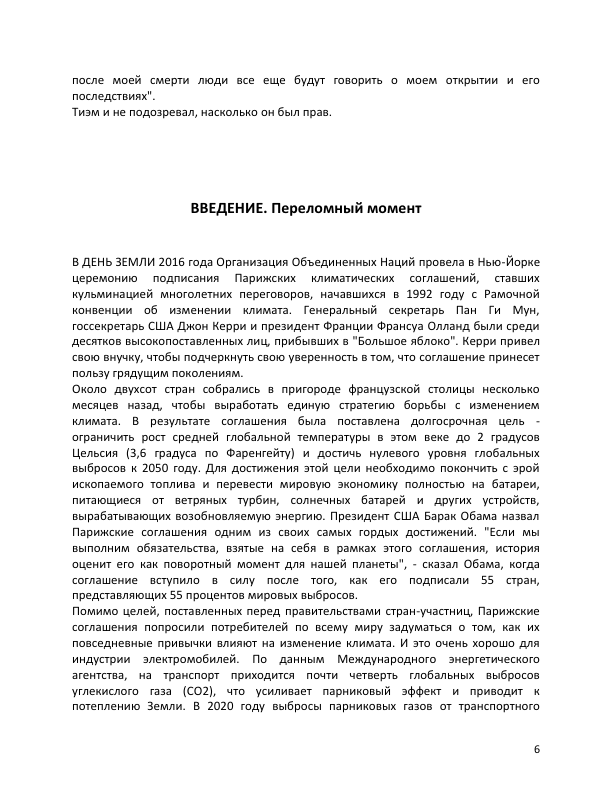

In [65]:
results_ds[0]

In [107]:
len(final_text)

12737

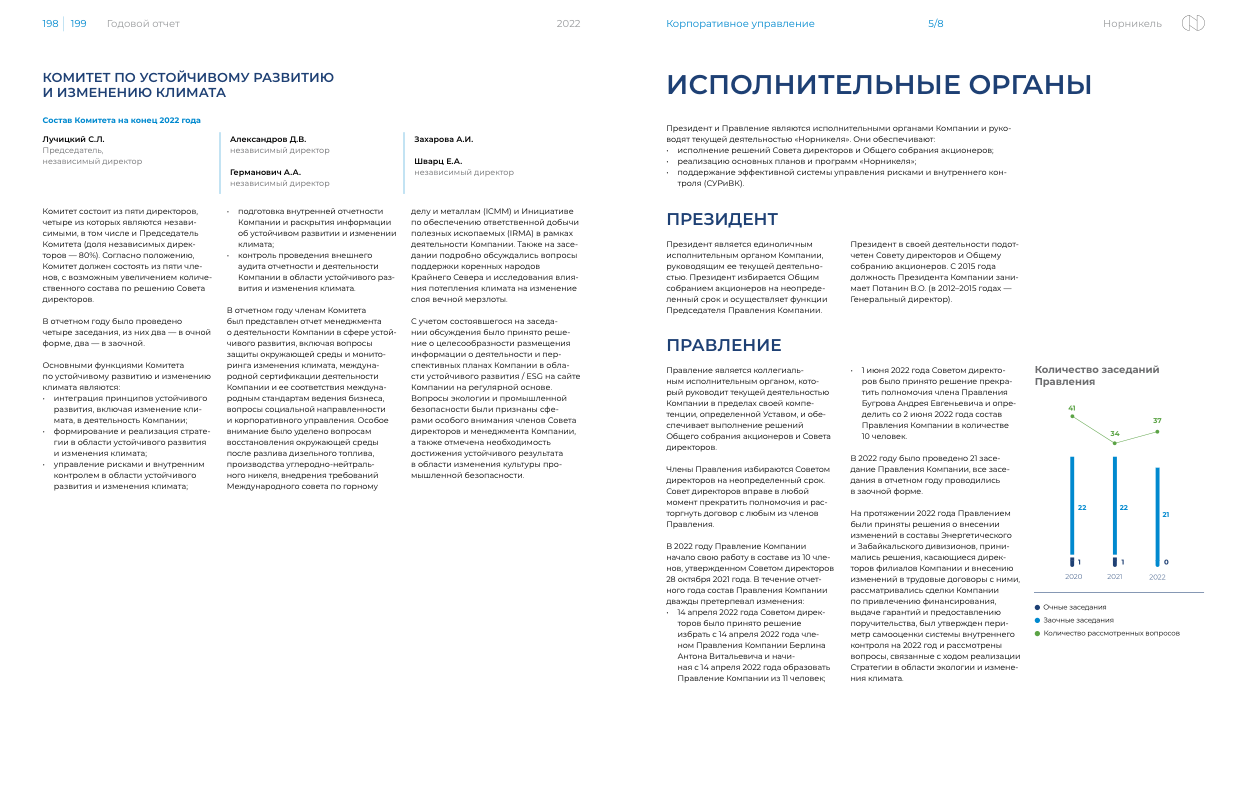

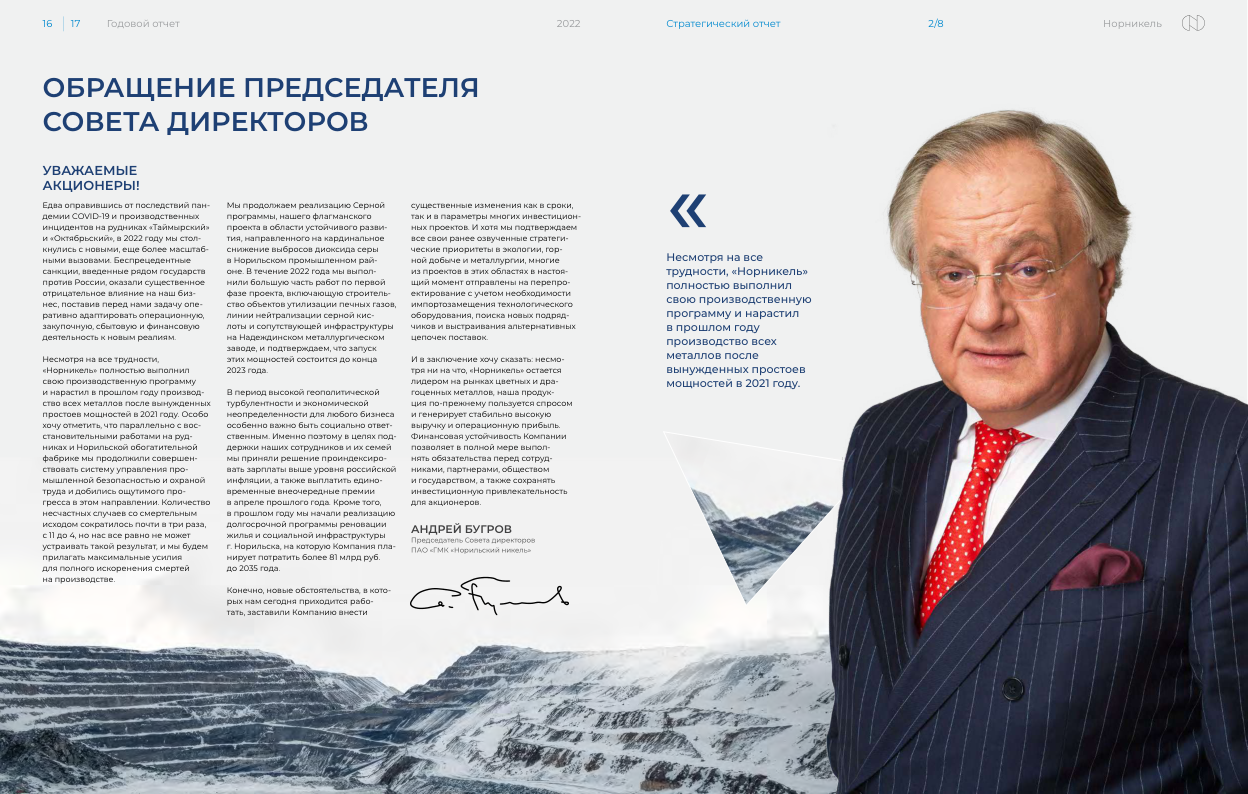

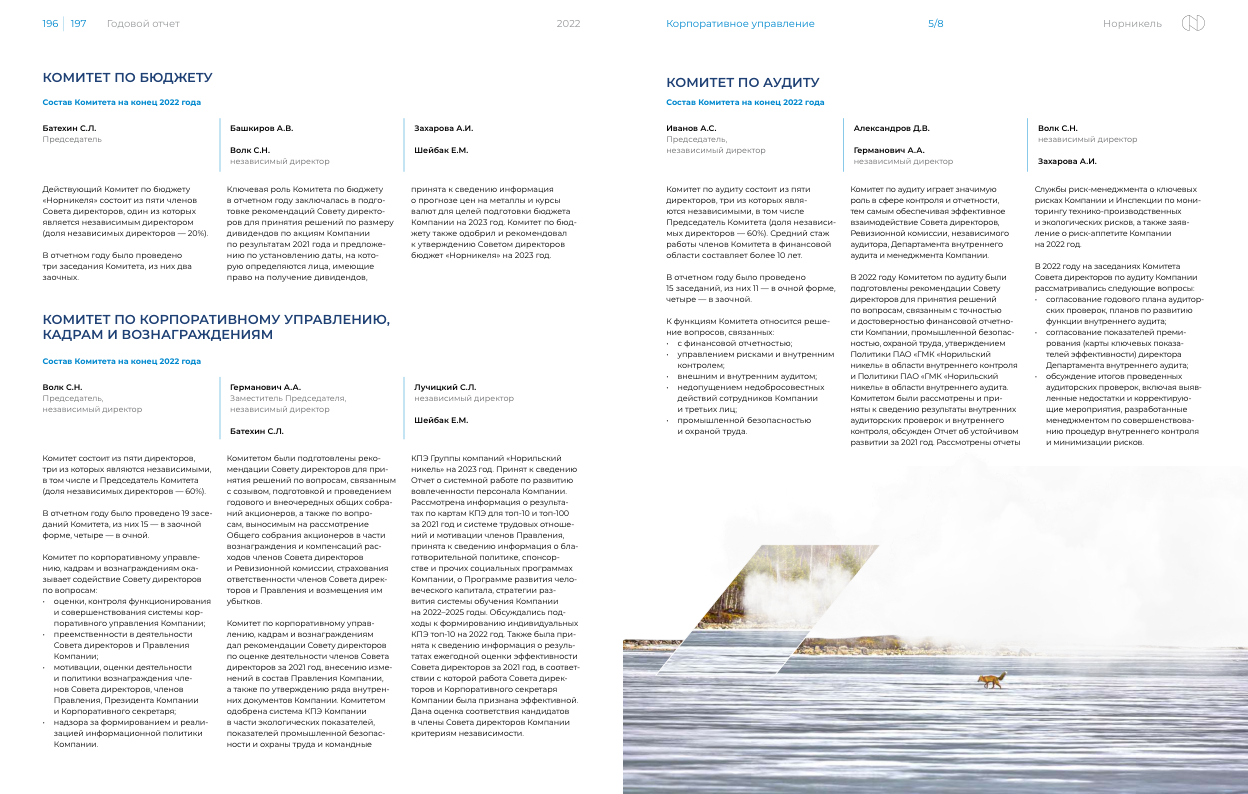

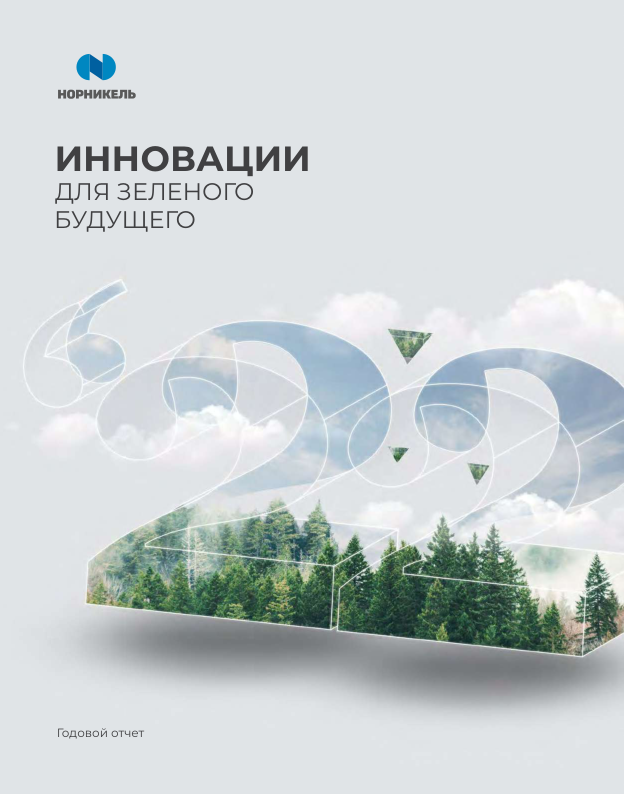

In [49]:
results_ds = search_by_text_and_return_images("Какое количество заседаний правительства было в двадцать первом году")

for row in results_ds:
    # display image
    display(row)